In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.api as tsa
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn import set_config
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs
import itertools

In [2]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [3]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)
    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')
    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )
    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)
    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")
        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 
        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")
    fig.tight_layout()
    
    return fig

In [4]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

In [5]:
def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [6]:
def evaluate_regression(reg, X_train, y_train, X_test, y_test, verbose = True,
                        output_frame=False):
    # Get predictions for training data
    y_train_pred = reg.predict(X_train)

    # Call the helper function to obtain regression metrics for training data
    results_train = regression_metrics(y_train, y_train_pred, verbose = verbose,
                                     output_dict=output_frame,
                                     label='Training Data')
    print()
    # Get predictions for test data
    y_test_pred = reg.predict(X_test)
    # Call the helper function to obtain regression metrics for test data
    results_test = regression_metrics(y_test, y_test_pred, verbose = verbose,
                                  output_dict=output_frame,
                                    label='Test Data' )

    # Store results in a dataframe if ouput_frame is True
    if output_frame:
        results_df = pd.DataFrame([results_train,results_test])
        # Set the label as the index 
        results_df = results_df.set_index('Label')
        # Set index.name to none to get a cleaner looking result
        results_df.index.name=None
        # Return the dataframe
        return results_df.round(3)

In [7]:
df = pd.read_csv('Data/WMT.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5479 entries, 0 to 5478
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5479 non-null   object 
 1   Adj Close  5284 non-null   float64
dtypes: float64(1), object(1)
memory usage: 85.7+ KB


,Date,Adj Close
0,2000-01-03,44.915394
1,2000-01-04,43.234756
2,2000-01-05,42.352402
3,2000-01-06,42.814564
4,2000-01-07,46.049828


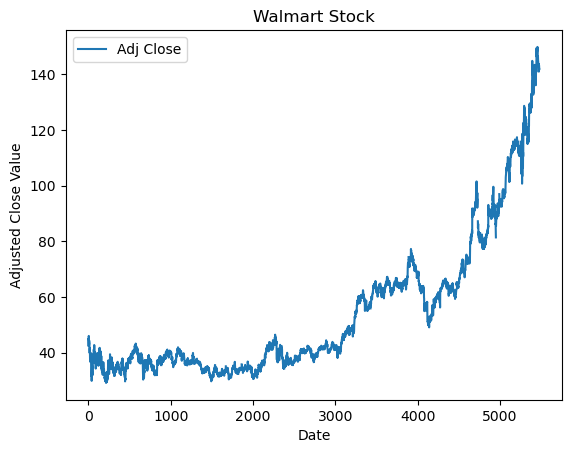

In [8]:
ax = df.plot()
ax.set(ylabel='Adjusted Close Value', xlabel='Date', title='Walmart Stock');

In [9]:
df['Date'] = pd.to_datetime(df['Date'], format = '%Y-%m-%d')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5479 entries, 0 to 5478
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5479 non-null   datetime64[ns]
 1   Adj Close  5284 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 85.7 KB


In [10]:
df = df.set_index('Date')
df.head()

,Adj Close
Date,
2000-01-03,44.915394
2000-01-04,43.234756
2000-01-05,42.352402
2000-01-06,42.814564
2000-01-07,46.049828


In [11]:
df.index

DatetimeIndex(['2000-01-03', '2000-01-04', '2000-01-05', '2000-01-06',
               '2000-01-07', '2000-01-10', '2000-01-11', '2000-01-12',
               '2000-01-13', '2000-01-14',
               ...
               '2020-12-18', '2020-12-21', '2020-12-22', '2020-12-23',
               '2020-12-24', '2020-12-25', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', name='Date', length=5479, freq=None)

In [12]:
df = df.asfreq('B')
df = df.loc['2010-02-01':]

In [36]:
df.isnull().sum()

Adj Close    0
dtype: int64

In [37]:
df = df.ffill()
df.isnull().sum()

Adj Close    0
dtype: int64

In [38]:
train, test = train_test_split(df, test_size = .25)

In [39]:
df.shape

(2849, 1)

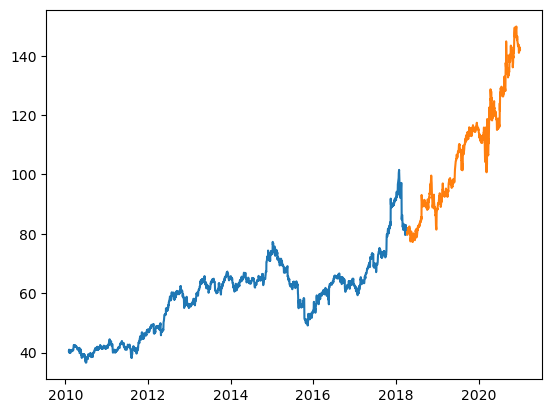

In [40]:
plt.plot(train)
plt.plot(test);

In [41]:
get_adfuller_results(df)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,1.429363,23,2825,0.997244,0.05,False


In [42]:
df_diff = df.diff().dropna()
get_adfuller_results(df_diff)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-12.168517,22,2825,0.0,0.05,True


In [43]:
ndiffs(df)

1

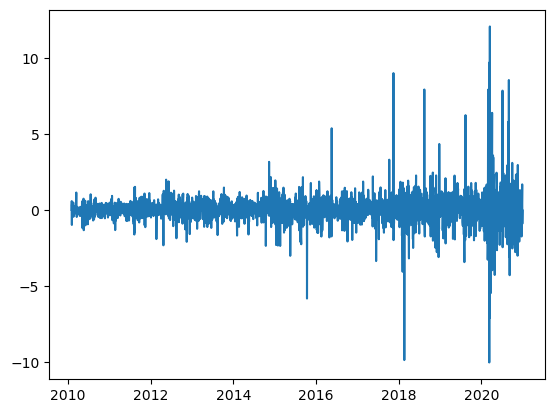

In [44]:
plt.plot(df_diff);

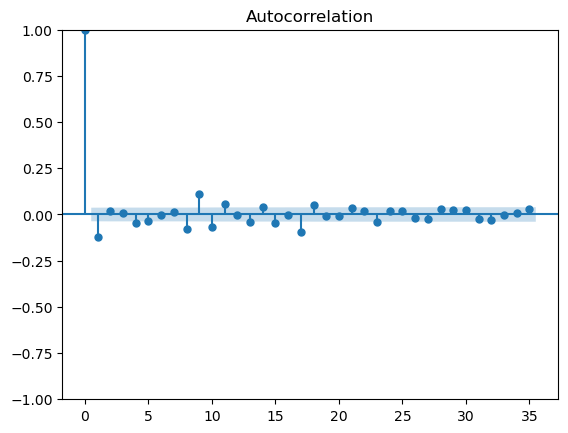

In [45]:
tsa.graphics.plot_acf(df_diff);

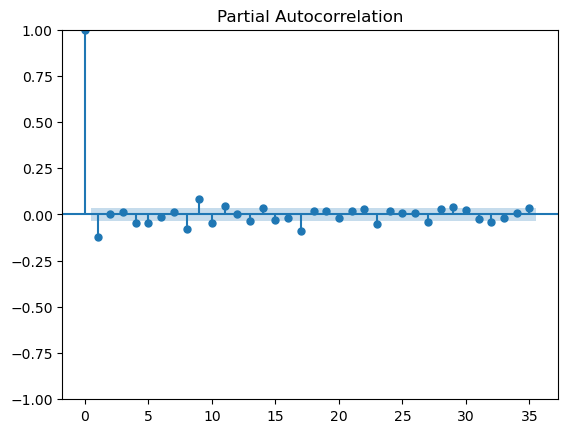

In [46]:
tsa.graphics.plot_pacf(df_diff, method='ywm');

In [47]:
p = 0
d = 1
q = 3
model = tsa.ARIMA(train, order = (p,d,q)).fit()
model

In [48]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 2136
Model:                 ARIMA(0, 1, 3)   Log Likelihood               -2193.610
Date:                Tue, 06 Feb 2024   AIC                           4395.220
Time:                        17:05:11   BIC                           4417.885
Sample:                    02-01-2010   HQIC                          4403.514
                         - 04-09-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0109      0.012     -0.919      0.358      -0.034       0.012
ma.L2         -0.0538      0.019     -2.771      0.006      -0.092      -0.016
ma.L3         -0.0273      0.017     -1.603      0.109      -0.061       0.006
sigma2         0.4570      0.003    132.695      0.000       0.450       0.464
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            151668.17
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               4.53   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        44.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [49]:
preds_df = model.get_forecast(steps=len(test)).summary_frame()

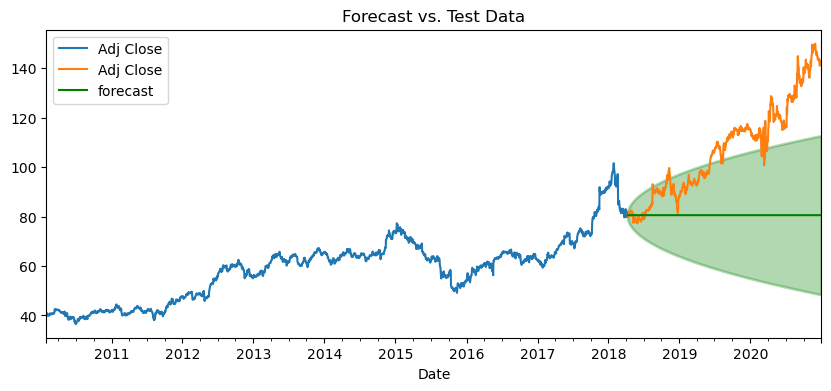

In [50]:
plot_forecast(train, test, preds_df, title='Forecast vs. Test Data');

In [51]:
regression_metrics_ts(test, preds_df['mean'])

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 27.041
- MSE = 1,078.631
- RMSE = 32.843
- R^2 = -2.008
- MAPE = 22.91%


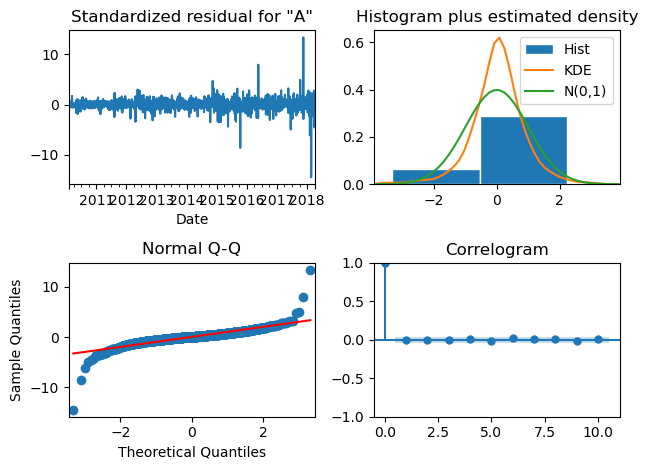

In [52]:
model.plot_diagnostics()
plt.tight_layout()

In [63]:
p_values = range(0, 6)  
d_values = [1]          
q_values = range(0, 6)  

pdq_to_try = list(itertools.product(p_values, d_values, q_values))
                                            
pdq_to_try

[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 1, 5),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (1, 1, 4),
 (1, 1, 5),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (2, 1, 4),
 (2, 1, 5),
 (3, 1, 0),
 (3, 1, 1),
 (3, 1, 2),
 (3, 1, 3),
 (3, 1, 4),
 (3, 1, 5),
 (4, 1, 0),
 (4, 1, 1),
 (4, 1, 2),
 (4, 1, 3),
 (4, 1, 4),
 (4, 1, 5),
 (5, 1, 0),
 (5, 1, 1),
 (5, 1, 2),
 (5, 1, 3),
 (5, 1, 4),
 (5, 1, 5)]

In [64]:
# define starting aic as infinity
best_aic = float("inf")  

# define baseline for pdq
best_pdq = (0,0,0)

# Loop through each combination
for pdq in pdq_to_try:
    
    model = tsa.ARIMA(train, order=pdq)
                              
    result = model.fit()
    
    print(pdq, result.aic)      
    
    # If lower, replace best AIC with new value
    if result.aic < best_aic:
        
        best_aic = result.aic
        best_pdq = pdq

# Print the best orders and AIC score
print("Best AIC:", best_aic)
print("Best pdq:", best_pdq)

(0, 1, 0) 4397.292331141389
(0, 1, 1) 4399.084869119841
(0, 1, 2) 4394.874646291211
(0, 1, 3) 4395.219670789512
(0, 1, 4) 4397.007799770043
(0, 1, 5) 4398.684254529006
(1, 1, 0) 4399.107239066912
(1, 1, 1) 4397.710010705735
(1, 1, 2) 4395.7120337013475
(1, 1, 3) 4396.4615046581075
(1, 1, 4) 4398.4570677136235
(1, 1, 5) 4400.992403647337
(2, 1, 0) 4394.939957069283
(2, 1, 1) 4395.547357004244
(2, 1, 2) 4397.377860160588
(2, 1, 3) 4398.454283174677
(2, 1, 4) 4400.447419372609


C:\Users\carlo\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 5) 4378.891356085254
(3, 1, 0) 4395.2474814845555
(3, 1, 1) 4396.743996724554


C:\Users\carlo\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\carlo\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 1, 2) 4398.6521413175815
(3, 1, 3) 4396.278950247826
(3, 1, 4) 4402.417422822081


C:\Users\carlo\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 5) 4382.339334411008
(4, 1, 0) 4397.208935306362
(4, 1, 1) 4398.702406123077


C:\Users\carlo\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\carlo\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 1, 2) 4400.593446297222


C:\Users\carlo\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 3) 4400.2563518816805


C:\Users\carlo\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 4) 4397.582837482461


C:\Users\carlo\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 5) 4389.744729787093
(5, 1, 0) 4398.515885617023
(5, 1, 1) 4400.1608893994035


C:\Users\carlo\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\carlo\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\carlo\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\carlo\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregres

(5, 1, 2) 4399.370094115284


C:\Users\carlo\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 1, 3) 4384.135288033764


C:\Users\carlo\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 1, 4) 4397.819265560017
(5, 1, 5) 4386.596498937492
Best AIC: 4378.891356085254
Best pdq: (2, 1, 5)


C:\Users\carlo\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [65]:
p = 2
d = 1
q = 5
model = tsa.ARIMA(train, order=(p,d,q)).fit()
model.summary()

C:\Users\carlo\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 2136
Model:                 ARIMA(2, 1, 5)   Log Likelihood               -2181.446
Date:                Tue, 06 Feb 2024   AIC                           4378.891
Time:                        17:32:59   BIC                           4424.221
Sample:                    02-01-2010   HQIC                          4395.481
                         - 04-09-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2567      0.009    -28.886      0.000      -0.274      -0.239
ar.L2         -0.9856      0.011    -91.628      0.000      -1.007      -0.965
ma.L1          0.2528      0.015     16.797      0.000       0.223       0.282
ma.L2          0.9375      0.023     40.594      0.000       0.892       0.983
ma.L3         -0.0515      0.023     -2.287      0.022      -0.096      -0.007
ma.L4         -0.0542      0.022     -2.465      0.014      -0.097      -0.011
ma.L5         -0.0556      0.018     -3.084      0.002      -0.091      -0.020
sigma2         0.4512      0.004    108.137      0.000       0.443       0.459
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):            139710.48
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               4.43   Skew:                            -0.60
Prob(H) (two-sided):                  0.00   Kurtosis:                        42.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [66]:
preds_df = model.get_forecast(steps=len(test)).summary_frame()

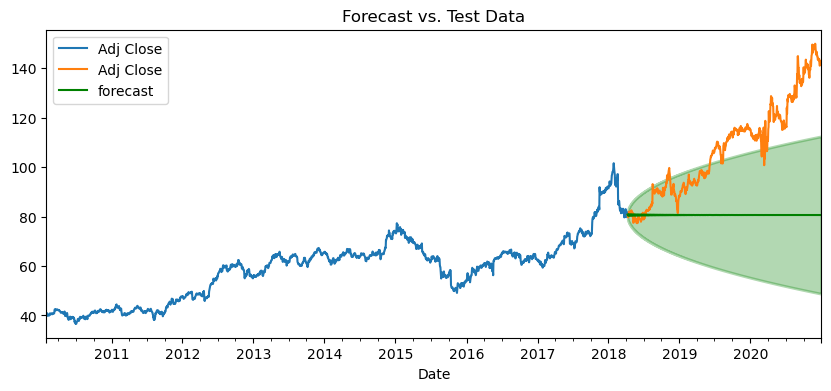

In [67]:
plot_forecast(train, test, preds_df, title='Forecast vs. Test Data');

In [68]:
regression_metrics_ts(test, preds_df['mean'])

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 26.989
- MSE = 1,075.509
- RMSE = 32.795
- R^2 = -1.999
- MAPE = 22.86%


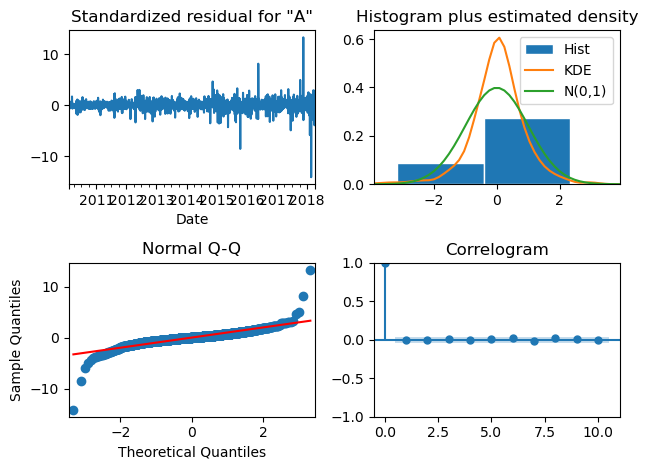

In [69]:
model.plot_diagnostics()
plt.tight_layout()

- My model is not accurate because it has a MAPE of 22.86%.
- The model performed not great because the forecast and test data do not match.